# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

 - Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# установим необходимые библиотеки
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# загрузим датасети
labels = pd.read_csv('/datasets/faces/labels.csv') 

In [3]:
print(labels.head(10))

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39


In [4]:
# посмотрим информацию о датасете
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# посмотрим на значения столбца real_age
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# посмотрим дубликаты
labels.duplicated().sum()

0

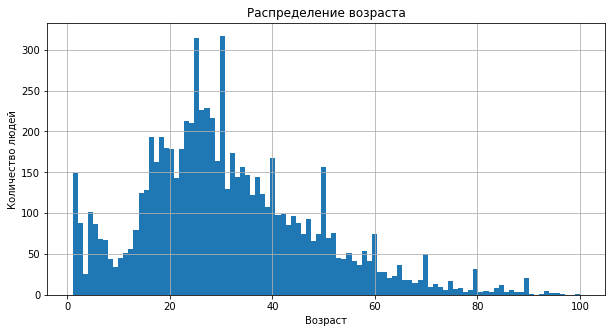

In [7]:
# посмотрим распределения возраста в датасете
labels.hist(bins=100, figsize=(10,5))
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.show()

In [8]:
# с помощью загрузчика создадим датасет из фотографий
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [9]:
# рассмотрим параметры для тренировочной выборки
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

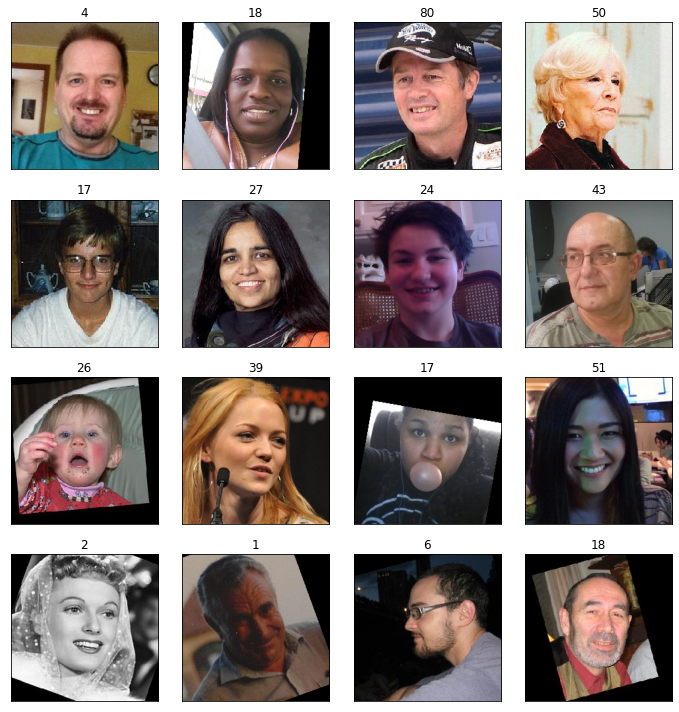

In [10]:
# взглянем на изображения
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(label=labels['real_age'][i])
    plt.tight_layout()

**Вывод:** Нам дан чистый датасет с корректными форматами, без пропусков, без дубликатов. В распределении основная масса людей в возрасте от 15 до 45 лет. Средний возраст составляет 31 год, при том что 75% данных это лица до 41 года. Минимальный возраст 1 год, а максимальный 100 лет. Но как мы можем видеть на фотографиях разметка возрастов не везде корректна. Например, человек, которому один год, на самом деле преклонных лет (см. нижний ряд фото).

## Обучение модели

**Код обучения модели и её результат.**

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, vertical_flip=True, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory = path + '/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    train_data = train_datagen_flow
    return train_data

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory = path + '/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    test_data = test_datagen_flow
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/7
178/178 - 134s - loss: 265.7462 - mae: 11.7759 - val_loss: 902.5834 - val_mae: 25.2130
Epoch 2/7
178/178 - 40s - loss: 102.8512 - mae: 7.6507 - val_loss: 417.7952 - val_mae: 15.3245
Epoch 3/7
178/178 - 38s - loss: 76.4470 - mae: 6.6197 - val_loss: 239.7536 - val_mae: 11.6372
Epoch 4/7
178/178 - 38s - loss: 62.7192 - mae: 6.0061 - val_loss: 135.5556 - val_mae: 8.8331
Epoch 5/7
178/178 - 38s - loss: 52.3623 - mae: 5.5153 - val_loss: 123.5341 - val_mae: 8.6452
Epoch 6/7
178/178 - 38s - loss: 46.5237 - mae: 5.1244 - val_loss: 110.6196 - val_mae: 8.1221
Epoch 7/7
178/178 - 39s - loss: 40.4670 - mae: 4.8255 - val_loss: 80.6736 - val_mae: 6.8848
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 80.6736 - mae: 6.8848
Test MAE: 6.8848

```

**Вывод:** Модель нейронной сети была построена на базе ResNet50. Удалось получить MAE на тесте равным 6.8848, что < 7 и по условию задачи является отличным результатом.

## Анализ обученной модели

В результате исследования мы получили модель которая с хорошей точностью может определять возраст людей по фотографии. Погрешность (МАЕ) составляет < 7 лет, а точнее 6,88. Вероятно данная модель может работать еще лучше если на вход (и для обучения) будет получать более четкие снимки, без лишних предметов и с корректной возрастной разметкой.

Но уже сейчас для сети «Хлеб-Соль» можно рекомендовать модель чтобы предлагать товары, которые могут заинтересовать покупателей той или иной возрастной группы. Но для контроля реализации алкоголя модель стоит совершенствовать, т.к. МАЕ все же велика.